## Requirement 1

This file fulfills requirement 1 at the "Best" level

- When a user clicks on a movie, they receive recommendations based on similarity.
- A hybrid model combines content-based filtering (TF-IDF on title, cast, director, genre) and collaborative filtering (user ratings).
- If a movie lacks rating data, the system falls back to content-based results (avoids the cold start problem).

## Data Understanding

In this section, we load and inspect the movie ratings dataset. This includes understanding the structure of the data, identifying important fields like 'title', 'cast', 'director', and genre related columns, and chekcingfor missing or duplicate values.

We also took a look at the shape of the content of the data to confirm its loaded correctly and ready for the next step.

Number of unique movies: 8508
Number of ratings: 2147
Sample movie data:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water             None   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans             None   
4      s5  TV Show           Kota Factory             None   

                                                cast        country  \
0  Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...  United States   
1  Ama Qamata Khosi Ngema Gail Mabalane Thabang M...   South Africa   
2  Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...           None   
3                                               None           None   
4  Mayur More Jitendra Kumar Ranjan Raj Alam Khan...          India   

   release_year rating   duration  \
0          2020  PG-13     90 min   
1          2021  TV-MA  2 Seasons   
2          2021 

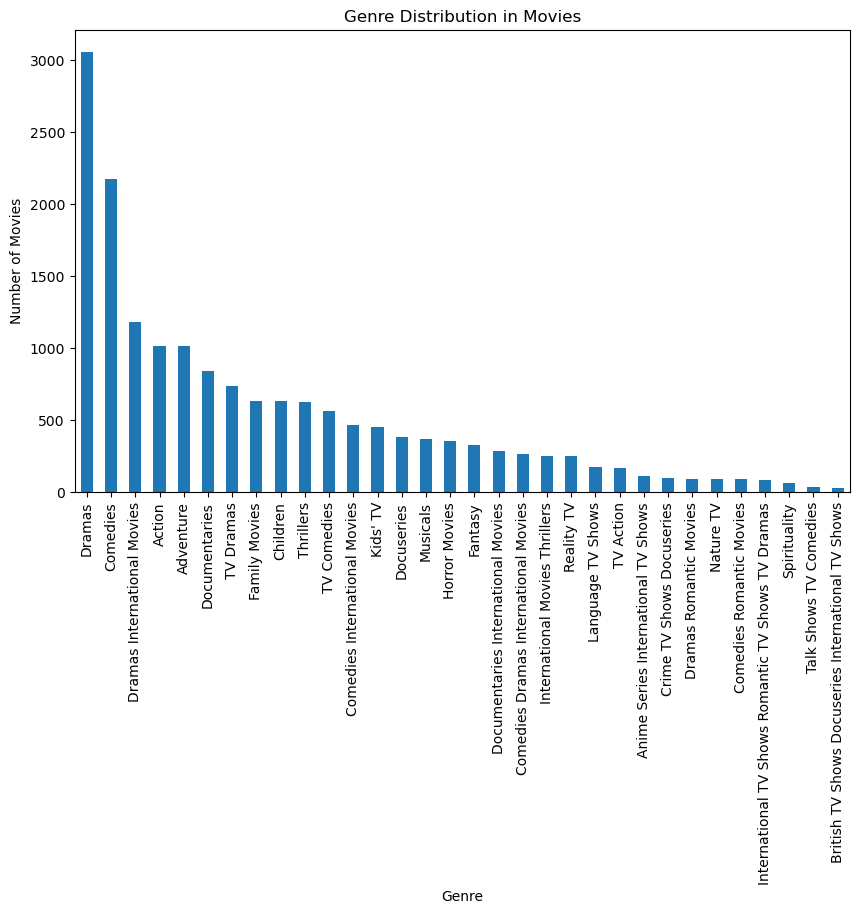

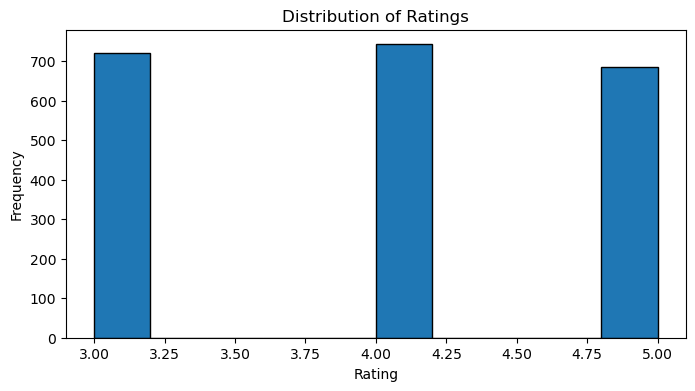

In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Data Understanding:
# Step 1: Load the data from the SQLite database.
conn = sqlite3.connect('Movies.db')

# Load the movies and ratings tables
movies = pd.read_sql_query("SELECT * FROM movies_titles;", conn)
ratings = pd.read_sql_query("SELECT * FROM movies_ratings;", conn)

# Close the connection
conn.close()

# Step 2: Explore the data
print("Number of unique movies:", len(movies['show_id'].unique()))
print("Number of ratings:", len(ratings))
print("Sample movie data:")
print(movies.head())
print("Sample rating data:")
print(ratings.head())

# Additional statistics
n_ratings = len(ratings)
n_movies = len(movies['show_id'].unique())
n_users = len(ratings['user_id'].unique())

print(f"\nNumber of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings / n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings / n_movies, 2)}")

# Data Visualization: Distribution of movie genres
genres = movies.iloc[:, 10:].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
genres.plot(kind='bar')
plt.title("Genre Distribution in Movies")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

# Data Visualization: Distribution of ratings
plt.figure(figsize=(8, 4))
ratings['rating'].plot(kind='hist', bins=10, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

## Data Preperation

this section focuses on cleaning and preparing the data for modeling

- We handle missing values in key columns like 'title', 'cast', 'director', and 'rating'.
- For genres, since they are appear as multiple binary columns, we combined them into a single string using all active genre lables.
- We then constructed a new 'combined_features' column that merges 'title', 'director', and 'cast', and the derived 'genres' column. This brought the text field that will be used to compute content similarity between movies.
- The combined text is normalized to lowercase for consistent text matching

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Data Preparation:
# Step 1: Clean the data by filling missing values
movies['title'].fillna('', inplace=True)
movies['director'].fillna('', inplace=True)
movies['cast'].fillna('', inplace=True)

# Handle missing values in ratings as well
ratings['rating'].fillna(0, inplace=True)

# Step 2: Combine binary genre columns into a single string
genre_columns = ['Action', 'Adventure', 'Anime Series International TV Shows', 
                 'British TV Shows Docuseries International TV Shows', 'Children', 
                 'Comedies', 'Comedies Dramas International Movies', 
                 'Comedies International Movies', 'Comedies Romantic Movies', 
                 'Crime TV Shows Docuseries', 'Documentaries', 
                 'Documentaries International Movies', 'Docuseries', 'Dramas', 
                 'Dramas International Movies', 'Dramas Romantic Movies', 
                 'Family Movies', 'Fantasy', 'Horror Movies', 
                 'International Movies Thrillers', 
                 'International TV Shows Romantic TV Shows TV Dramas', 
                 "Kids' TV", 'Language TV Shows', 'Musicals', 'Nature TV', 
                 'Reality TV', 'Spirituality', 'TV Action', 'TV Comedies', 
                 'TV Dramas', 'Talk Shows TV Comedies', 'Thrillers']

# Create a "genres" column
movies['genres'] = movies[genre_columns].apply(
    lambda row: ' '.join([col for col in genre_columns if row[col] == 1]), axis=1
)

# Step 3: Combine title, director, cast, and genres into one column for content-based filtering
movies['combined_features'] = (
    movies['title'] + ' ' +
    movies['director'] + ' ' +
    movies['cast'] + ' ' +
    movies['genres']
)

# Normalize text for consistency
movies['combined_features'] = movies['combined_features'].str.lower()

# Step 4: Verify cleaning
print("Number of movies after cleaning:", len(movies['show_id'].unique()))
print("Sample of combined features:")
print(movies[['show_id', 'combined_features']].head())

# Step 5: Use TF-IDF to vectorize the combined features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

# Step 6: Calculate the cosine similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 7: Check similarity matrix shape
print("Cosine similarity matrix shape:", cosine_sim.shape)

# Step 8: Sample similarity values
print("Sample cosine similarity values:")
print(cosine_sim[:5, :5])


C:\Users\mclai\AppData\Local\Temp\ipykernel_26164\3229305829.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['title'].fillna('', inplace=True)
C:\Users\mclai\AppData\Local\Temp\ipykernel_26164\3229305829.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

Number of movies after cleaning: 8508
Sample of combined features:
  show_id                                  combined_features
0      s1  dick johnson is dead kirsten johnson michael h...
1      s2  blood & water  ama qamata khosi ngema gail mab...
2      s3  ganglands julien leclercq sami bouajila tracy ...
3      s4      jailbirds new orleans   docuseries reality tv
4      s5  kota factory  mayur more jitendra kumar ranjan...
Cosine similarity matrix shape: (8508, 8508)
Sample cosine similarity values:
[[1.         0.         0.         0.         0.        ]
 [0.         1.         0.00244003 0.00618599 0.00302846]
 [0.         0.00244003 1.         0.00855925 0.00419033]
 [0.         0.00618599 0.00855925 1.         0.01062337]
 [0.         0.00302846 0.00419033 0.01062337 1.        ]]


## Modeling & Evaluation

To acheive the best-case scenario outlined in the project requirements, we implemented a hybrid recommendation model that combines both content-based and collaborative filtering.

- Content-based Filtering
    - 'title'
    - 'cast'
    - 'director'
    - 'genres'
These features are combined into a single string per movie, and cosine similarity is calculated to measure how similar one movie is to another based on its content.

- Collabrotive filtering
    - We also create a 'user-item matrix' using user ratings. By calculating cosine similarity between movies based on user behavior, we identify movies that are liked by similar groups of users.

- Hybrid Logic
    We combined the two approaches using a weighted average
    - 60% weight from content-based similarity
    - 40% weight from collaborative similarity

We then inspected the dimensions of the cosine similarity matrix and verify that the scores make sense by viewing a sample of the values.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Modeling and Evaluation:

# Step 1: Build a TF-IDF vectorizer to analyze the combined features (Content-Based)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

# Step 2: Calculate cosine similarity between movies (Content-Based Similarity Matrix)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Create user-item matrix for Collaborative Filtering
user_item_matrix = ratings.pivot_table(index='user_id', columns='show_id', values='rating').fillna(0)

# Step 4: Calculate item-based cosine similarity (Collaborative Filtering)
collaborative_sim = cosine_similarity(user_item_matrix.T)

# Step 5: Align collaborative similarity matrix with the content-based matrix
# Create mapping from movie show_id to index
movie_id_to_index = {show_id: idx for idx, show_id in enumerate(movies['show_id'])}

# Ensure movie order matches between matrices
ordered_ids = [mid for mid in user_item_matrix.columns if mid in movie_id_to_index]
ordered_indices = [movie_id_to_index[mid] for mid in ordered_ids]

# Filter both matrices to match indices
content_sim_filtered = cosine_sim[ordered_indices][:, ordered_indices]
collab_sim_filtered = collaborative_sim[np.ix_(range(len(ordered_ids)), range(len(ordered_ids)))]

# Step 6: Normalize both matrices
scaler = MinMaxScaler()
content_sim_scaled = scaler.fit_transform(content_sim_filtered)
collab_sim_scaled = scaler.fit_transform(collab_sim_filtered)

# Step 7: Combine into hybrid similarity matrix
hybrid_sim = 0.6 * content_sim_scaled + 0.4 * collab_sim_scaled

# Step 8: Create recommendation function with fallback
def get_recommendations(idx, num_recommendations=10):
    try:
        if idx in ordered_indices:
            # Use hybrid similarity
            local_idx = ordered_indices.index(idx)
            sim_scores = list(enumerate(hybrid_sim[local_idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
            global_indices = [ordered_indices[i[0]] for i in sim_scores]
        else:
            # Fallback to content-based similarity
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
            global_indices = [i[0] for i in sim_scores]

        return movies['show_id'].iloc[global_indices].tolist()
    except Exception as e:
        print(f"Error in recommendation: {e}")
        return ['None'] * num_recommendations

# Step 9: Test the recommendation function with a sample movie index
sample_index = 0  # Example movie index from movies dataframe
recommended_movies = get_recommendations(sample_index)
print(f"Hybrid Recommendations for movie ID {movies['show_id'].iloc[sample_index]}: {recommended_movies}")


Hybrid Recommendations for movie ID s1: ['s5895', 's3336', 's6399', 's3718', 's7623', 's7016', 's7600', 's6896', 's6661', 's4530']


## Deployment

In this section, we prepare the model output for it to integrate in our backend system.

- After computing the cosine similarity scores, we generate a list of top recommended movies for each title.
- These recommendations are exported to a CSV file ('structured_recommendations.csv), which can be queried by the backend when a user clicks on a specific movie.
- This allows for real-time delivery of content-based recommendations on the movie detail page of the website.

In [14]:
# Deployment:
# Step 1: Generate recommendations for all movies and save them to a CSV file
def generate_recommendations():
    all_recommendations = []

    for idx, row in movies.iterrows():
        # Get recommendations for the current movie index
        recommendations = get_recommendations(idx)

        # Append the movie ID, title, and recommendations to the list
        all_recommendations.append({
            'show_id': row['show_id'],
            'movie': row['title'],
            'recommendation1': recommendations[0] if len(recommendations) > 0 else 'None',
            'recommendation2': recommendations[1] if len(recommendations) > 1 else 'None',
            'recommendation3': recommendations[2] if len(recommendations) > 2 else 'None',
            'recommendation4': recommendations[3] if len(recommendations) > 3 else 'None',
            'recommendation5': recommendations[4] if len(recommendations) > 4 else 'None',
            'recommendation6': recommendations[5] if len(recommendations) > 5 else 'None',
            'recommendation7': recommendations[6] if len(recommendations) > 6 else 'None',
            'recommendation8': recommendations[7] if len(recommendations) > 7 else 'None',
            'recommendation9': recommendations[8] if len(recommendations) > 8 else 'None',
            'recommendation10': recommendations[9] if len(recommendations) > 9 else 'None'
        })

    # Convert the list to a DataFrame and save to CSV
    recommendations_df = pd.DataFrame(all_recommendations)
    recommendations_df.to_csv('structured_recommendations.csv', index=False)
    print("Recommendations saved to structured_recommendations.csv")

# Run the recommendation generation function
generate_recommendations()


Recommendations saved to structured_recommendations.csv


## Automation

This section shows how the recommendation generation process can be automated.

- The entire pipeline from beginning to end is implemented in a modular way.
- By re-running the notebook or converting it into a script, updated recommendations can be generated automatically whenever the movie data is refreshed.
- This allows for easy integration into a scheduled pipeline or batch job to keep the recommendations up to date with minimal manual intervention.

Future improvements could include monitoring changes in the dataset and triggering the pipeline only when needed.

In [8]:
# Automation:
# Automate the entire process by running all steps in sequence
def run_pipeline():
    print("Starting automated pipeline...")
    generate_recommendations()
    print("Pipeline completed successfully.")

run_pipeline()

Starting automated pipeline...
Recommendations saved to structured_recommendations.csv
Pipeline completed successfully.


In [59]:
# Load the generated CSV to verify
recommendations_df = pd.read_csv('structured_recommendations.csv')
print("Number of recommendations in CSV:", len(recommendations_df))
print("Sample recommendations:")
print(recommendations_df.head())

Number of recommendations in CSV: 8508
Sample recommendations:
  show_id                  movie recommendation1 recommendation2  \
0      s1   Dick Johnson Is Dead           s5895           s6399   
1      s2          Blood & Water           s1515           s8317   
2      s3              Ganglands           s2669           s3426   
3      s4  Jailbirds New Orleans           s3838           s4808   
4      s5           Kota Factory           s2354           s8776   

  recommendation3 recommendation4 recommendation5 recommendation6  \
0           s3336           s3718           s7623           s7016   
1           s1594           s7092           s2540           s7619   
2           s5481           s4111           s3009           s1237   
3           s4951           s3229           s5714           s4945   
4           s8125           s2473           s2722           s7933   

  recommendation7 recommendation8 recommendation9 recommendation10  
0           s6896           s6661           